In [23]:
import os
import numpy
import torch
import sys
import argparse
import pandas
import time
import datetime
import math
import torch.utils.data as Data

from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import KernelPCA, PCA
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error
from numpy import linalg as LA

sys.path.append('../')

from src.cars.data import DataGenerator, define_filenames
from src.mnist.utils.pca_functions import my_scorer, anomaly_scorer
from src.utils.denormalize import denormalize
from src.cars.utils.pca_functions import compute_Z, compute_covariance_matrix, find_pcs, project_data

device = "cpu"

In [157]:
# General parameters
PATH_DATA_CARS = os.path.join(
    os.path.expanduser("~"), 'data/stanford_cars')
PATH_DATA_DOGS = os.path.join(
    os.path.expanduser("~"), 'data/stanford_dogs2')
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

p_train=0.01
p_test=0.1

# Define training parameters
hyper_params = {
    "NUM_WORKERS": 0,
    "IMAGE_SIZE": (100, 100),
    "TRAIN_SIZE": 2000,
    "TRAIN_NOISE": p_train,
    "TEST_SIZE": 1000,
    "TEST_NOISE": p_test,
    "ALPHA": p_test,  # level of significance for the test
    "GAMMA": [0.001, 0.01, 1],
    "N_COMP": 0.90
}

In [138]:
# Define some transformations
transform = transforms.Compose([
    transforms.Resize((hyper_params["IMAGE_SIZE"][1], hyper_params["IMAGE_SIZE"][1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Load data
train_x_files, test_x_files, train_y, test_y = define_filenames(
    PATH_DATA_DOGS, PATH_DATA_CARS, hyper_params["TRAIN_SIZE"],
    hyper_params["TEST_SIZE"], hyper_params["TRAIN_NOISE"],
    hyper_params["TEST_NOISE"])

train_data = DataGenerator(train_x_files,
                            train_y,
                            transform=transform,
                            image_size=hyper_params["IMAGE_SIZE"])

test_data = DataGenerator(test_x_files,
                          test_y,
                          transform=transform,
                          image_size=hyper_params["IMAGE_SIZE"])

train_loader = Data.DataLoader(dataset=train_data,
                                   batch_size=hyper_params["TRAIN_SIZE"],
                                   num_workers=hyper_params["NUM_WORKERS"],
                                   shuffle=False)

test_loader = Data.DataLoader(dataset=test_data,
                                  batch_size=hyper_params["TEST_SIZE"],
                                  num_workers=hyper_params["NUM_WORKERS"],
                                  shuffle=False)

In [139]:
# Split the train data into RGB
X_train = next(enumerate(train_loader))[1][0]
X_train_r = X_train[:, 0, :, :].flatten().reshape(hyper_params["TRAIN_SIZE"], hyper_params["IMAGE_SIZE"][1] * hyper_params["IMAGE_SIZE"][1]).numpy()
X_train_g = X_train[:, 1, :, :].flatten().reshape(hyper_params["TRAIN_SIZE"], hyper_params["IMAGE_SIZE"][1] * hyper_params["IMAGE_SIZE"][1]).numpy()
X_train_b = X_train[:, 2, :, :].flatten().reshape(hyper_params["TRAIN_SIZE"], hyper_params["IMAGE_SIZE"][1] * hyper_params["IMAGE_SIZE"][1]).numpy()

# Split the test data in RGB
X_test = next(enumerate(test_loader))[1][0]
X_test_r = X_test[:, 0, :, :].flatten().reshape(hyper_params["TEST_SIZE"], hyper_params["IMAGE_SIZE"][1] * hyper_params["IMAGE_SIZE"][1]).numpy()
X_test_g = X_test[:, 1, :, :].flatten().reshape(hyper_params["TEST_SIZE"], hyper_params["IMAGE_SIZE"][1] * hyper_params["IMAGE_SIZE"][1]).numpy()
X_test_b = X_test[:, 2, :, :].flatten().reshape(hyper_params["TEST_SIZE"], hyper_params["IMAGE_SIZE"][1] * hyper_params["IMAGE_SIZE"][1]).numpy()

In [ ]:
# Run PCA reconstructions
# R
COV = compute_covariance_matrix(X_train_r)
L, PCS = find_pcs(COV)
print(f"R 80% of variance : {numpy.argwhere(numpy.cumsum(L)/numpy.sum(L)>=hyper_params['N_COMP'])[0]}")
N_COMP = int(numpy.argwhere(numpy.cumsum(L)/numpy.sum(L)>=0.8)[0])
X_train_kpca = project_data(X_train_r, PCS, L, N_COMP, 0)
X_test_kpca = project_data(X_test_r, PCS, L, N_COMP, 0)
component_matrix = numpy.delete(PCS, range(N_COMP, PCS.shape[1]), axis=1)
Ut = component_matrix.T
X_train_back_r = numpy.dot(X_train_kpca, Ut)
X_test_back_r = numpy.dot(X_test_kpca, Ut)

# G
COV = compute_covariance_matrix(X_train_g)
L, PCS = find_pcs(COV)
print(f"G 80% of variance : {numpy.argwhere(numpy.cumsum(L)/numpy.sum(L)>=hyper_params['N_COMP'])[0]}")
N_COMP = int(numpy.argwhere(numpy.cumsum(L)/numpy.sum(L)>=0.8)[0])
X_train_kpca = project_data(X_train_g, PCS, L, N_COMP, 0)
X_test_kpca = project_data(X_test_g, PCS, L, N_COMP, 0)
component_matrix = numpy.delete(PCS, range(N_COMP, PCS.shape[1]), axis=1)
Ut = component_matrix.T
X_train_back_g = numpy.dot(X_train_kpca, Ut)
X_test_back_g = numpy.dot(X_test_kpca, Ut)

# B
COV = compute_covariance_matrix(X_train_b)
L, PCS = find_pcs(COV)
print(f"B 80% of variance : {numpy.argwhere(numpy.cumsum(L)/numpy.sum(L)>=hyper_params['N_COMP'])[0]}")
N_COMP = int(numpy.argwhere(numpy.cumsum(L)/numpy.sum(L)>=0.8)[0])
X_train_kpca = project_data(X_train_b, PCS, L, N_COMP, 0)
X_test_kpca = project_data(X_test_b, PCS, L,N_COMP, 0)
component_matrix = numpy.delete(PCS, range(N_COMP, PCS.shape[1]), axis=1)
Ut = component_matrix.T
X_train_back_b = numpy.dot(X_train_kpca, Ut)
X_test_back_b = numpy.dot(X_test_kpca, Ut)

In [141]:
# Small test
X_train_back_b.shape

0.8

In [149]:
# Compute the distance between original data and reconstruction
dist_train_r = numpy.linalg.norm(X_train_r - X_train_back_r, axis=1)
dist_train_g = numpy.linalg.norm(X_train_g - X_train_back_g, axis=1)
dist_train_b = numpy.linalg.norm(X_train_b - X_train_back_b, axis=1)
dist_train = numpy.mean([dist_train_r, dist_train_g, dist_train_b], axis=0)

dist_test_r = numpy.linalg.norm(X_test_r - X_test_back_r, axis=1)
dist_test_g = numpy.linalg.norm(X_test_g - X_test_back_g, axis=1)
dist_test_b = numpy.linalg.norm(X_test_b - X_test_back_b, axis=1)
dist_test = numpy.mean([dist_test_r, dist_test_g, dist_test_b], axis=0)

print(f"Train distances (min, mean, max): ({numpy.min(dist_train)}, {numpy.mean(dist_train)}, {numpy.max(dist_train)})")
print(f"Test distances (min, mean, max): ({numpy.min(dist_test)}, {numpy.mean(dist_test)}, {numpy.max(dist_test)})")

Train distances (min, mean, max): (14.67380428314209, 55.79161071777344, 92.32552337646484)
Test distances (min, mean, max): (16.682592391967773, 58.371788024902344, 116.7481918334961)


In [156]:
# Test performances on test
test_probs = numpy.array([numpy.sum(xi >= dist_train) / len(dist_train) for xi in dist_test], dtype=float)
test_anomalies_ind = numpy.argwhere(test_probs >= 1 - hyper_params["ALPHA"])
test_predictions = numpy.zeros(hyper_params["TEST_SIZE"])
test_predictions[test_anomalies_ind] = 1

test_recall = metrics.recall_score(test_y, test_predictions)
test_precision = metrics.precision_score(test_y, test_predictions)
test_f1_score = metrics.f1_score(test_y, test_predictions)
test_auc = metrics.roc_auc_score(test_y, test_probs)
test_average_precision = metrics.average_precision_score(test_y, test_predictions)

print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1_score}")
print(f"Test AUC: {test_auc}")
print(f"Test average Precision: {test_average_precision}")

Test Precision: 0.07920792079207921
Test Recall: 0.08
Test F1 Score: 0.07960199004975124
Test AUC: 0.3705
Test average Precision: 0.09833663366336635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

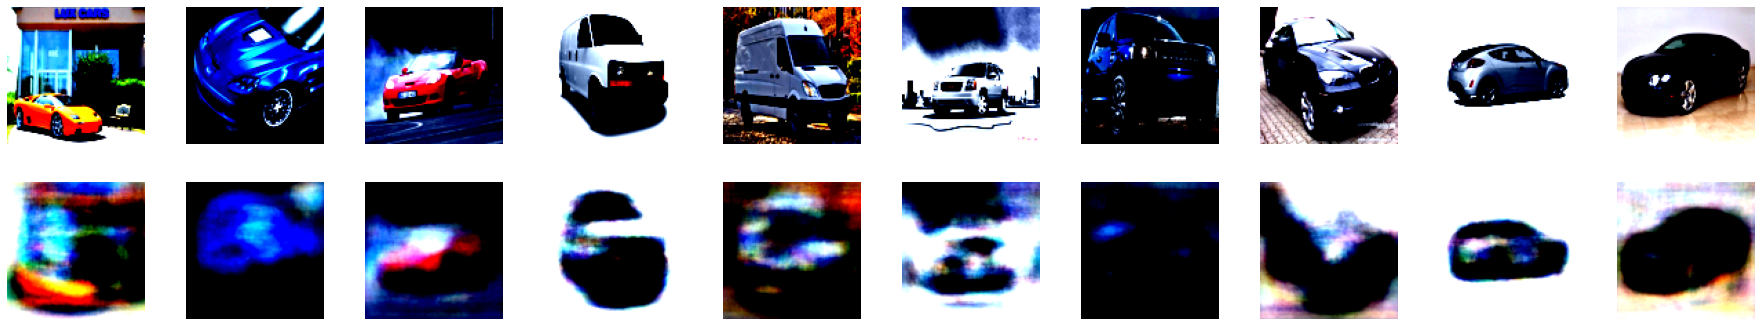

In [151]:
# Test some reconstruction on train
train_reconstructed_example = numpy.concatenate([numpy.expand_dims(X_train_back_r.reshape(hyper_params["TRAIN_SIZE"], hyper_params["IMAGE_SIZE"][1], hyper_params["IMAGE_SIZE"][1], order='F'), 3),
                                                 numpy.expand_dims(X_train_back_g.reshape(hyper_params["TRAIN_SIZE"], hyper_params["IMAGE_SIZE"][1], hyper_params["IMAGE_SIZE"][1], order='F'), 3),
                                                 numpy.expand_dims(X_train_back_b.reshape(hyper_params["TRAIN_SIZE"], hyper_params["IMAGE_SIZE"][1], hyper_params["IMAGE_SIZE"][1], order='F'), 3)], 
                                                axis=3)

plt.rcParams['figure.figsize'] = [25, 5]

fig, axs = plt.subplots(2, 10)
fig.tight_layout()
axs = axs.ravel()

samples = numpy.random.choice(numpy.arange(hyper_params["TRAIN_SIZE"]), 10, replace=False)

j = 0
for i in samples:
    image = X_train[i].transpose_(0,2).numpy()
    axs[j].imshow(image)
    axs[j].axis('off')
    
    image = train_reconstructed_example[i]
    axs[j+10].imshow(image)
    axs[j+10].axis('off')
    j += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

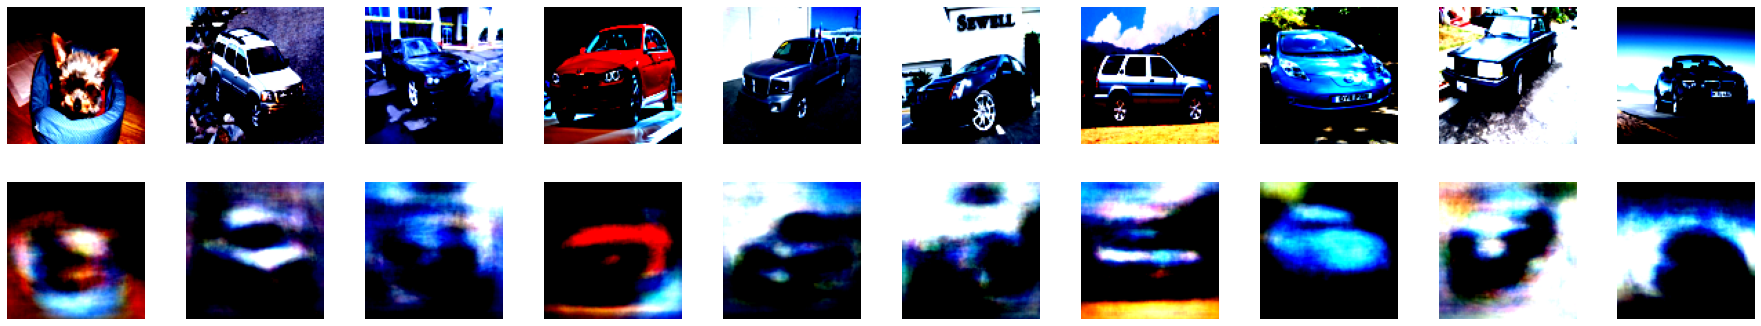

In [155]:
# Test some reconstruction on test
test_reconstructed_example = numpy.concatenate([numpy.expand_dims(X_test_back_r.reshape(hyper_params["TEST_SIZE"], hyper_params["IMAGE_SIZE"][1], hyper_params["IMAGE_SIZE"][1], order='F'), 3),
                                                numpy.expand_dims(X_test_back_g.reshape(hyper_params["TEST_SIZE"], hyper_params["IMAGE_SIZE"][1], hyper_params["IMAGE_SIZE"][1], order='F'), 3),
                                                numpy.expand_dims(X_test_back_b.reshape(hyper_params["TEST_SIZE"], hyper_params["IMAGE_SIZE"][1], hyper_params["IMAGE_SIZE"][1], order='F'), 3)], 
                                                 axis=3)

plt.rcParams['figure.figsize'] = [25, 5]

fig, axs = plt.subplots(2, 10)
fig.tight_layout()
axs = axs.ravel()

samples = numpy.random.choice(numpy.arange(hyper_params["TEST_SIZE"]), 10, replace=False)

j = 0
for i in samples:
    image = X_test[i].transpose_(0,2).numpy()
    axs[j].imshow(image)
    axs[j].axis('off')
    
    image = test_reconstructed_example[i]
    axs[j+10].imshow(image)
    axs[j+10].axis('off')
    j += 1

In [47]:
X_train_test = X_train[0, 0, :, :].flatten().reshape(1, 64 * 64)
print(X_train[0, 0, :, :])
print(X_train_test)
print(X_train_test.reshape(1, 64, 64))

train_reconstructed_example[i].shape

tensor([[ 2.2489,  2.2147,  2.1633,  ...,  0.0741,  0.3481,  0.7077],
        [ 2.2489,  2.2147,  2.1804,  ...,  0.1426,  0.5193,  0.7248],
        [ 2.2318,  2.1975,  2.1633,  ...,  0.2453,  0.5878,  0.5022],
        ...,
        [ 0.2453,  0.4166,  0.7248,  ..., -0.4911, -0.5253, -0.5082],
        [ 0.5364,  0.5022,  0.3823,  ..., -0.5253, -0.5424, -0.5082],
        [ 0.5364,  0.3309, -0.0287,  ..., -0.5424, -0.5424, -0.5082]])
tensor([[ 2.2489,  2.2147,  2.1633,  ..., -0.5424, -0.5424, -0.5082]])
tensor([[[ 2.2489,  2.2147,  2.1633,  ...,  0.0741,  0.3481,  0.7077],
         [ 2.2489,  2.2147,  2.1804,  ...,  0.1426,  0.5193,  0.7248],
         [ 2.2318,  2.1975,  2.1633,  ...,  0.2453,  0.5878,  0.5022],
         ...,
         [ 0.2453,  0.4166,  0.7248,  ..., -0.4911, -0.5253, -0.5082],
         [ 0.5364,  0.5022,  0.3823,  ..., -0.5253, -0.5424, -0.5082],
         [ 0.5364,  0.3309, -0.0287,  ..., -0.5424, -0.5424, -0.5082]]])


(64, 64, 3)

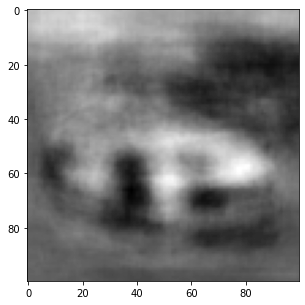

In [154]:
test = X_train_back_r.reshape(hyper_params["TRAIN_SIZE"], hyper_params["IMAGE_SIZE"][1], hyper_params["IMAGE_SIZE"][1], order='F')

plt.imshow(numpy.expand_dims(test[0], 2), cmap="gray")
